In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

warnings.simplefilter("ignore") #suppressing warnings use: warnings.resetwarnings() to reset back to default
#warnings.resetwarnings()

from datahelper import *

import startup_config_preferences

# Classes and Functions

In [10]:
class GrangerHelper:
    def __init__(self, df, fcol, input_values = None, target_descriptions = None):
        self.df = df.copy()
        self.fcol = fcol
        values = -1*df.Debit if input_values is None else input_values
        
        if not hasattr(self, "max_lag") or not hasattr(self, "time_col"):
            raise NotImplementedError("GrangerHelper is an abstract class, time_col and max_lag must be called from derived classes")
        
        if target_descriptions is None:
            self.df_crosstab = self.get_crosstab(values)
        else:
            self.df_crosstab = self.get_crosstab(values, GrangerHelper.outer_query(df, "Description", target_descriptions, "txn_amt"))

        self.results = GrangerHelper.granger_causality(self.df_crosstab, self.max_lag, self.fcol)

        txn_sums = self.df.groupby(["fyear", "Period"]).txn_amt.sum()
        df_peaks = ((txn_sums > txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("peaks").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("troughs").to_frame())
        df_trends = ((txn_sums > txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("downward").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("upward").to_frame())
        self.df_trends = self.df.groupby(["fyear", "Period", "desc1", "Account"]).txn_amt.sum().unstack("Account").join(df_peaks.join(df_trends).idxmax(axis = 1).rename("trends"))
        
    def set_scale (df, col):
        return df.copy().eval(f"{col} = ({col} - {col}.mean())/{col}.std()")

    def get_crosstab(self, value_col = 'txn_amt', target_col = 'txn_amt'):
        times = self.df[self.time_col] if type(self.time_col) == str else self.time_col
        features = self.df[self.fcol] if type(self.fcol) == str else self.fcol
        values = self.df[value_col] if type(value_col) == str else value_col
        targets = self.df[target_col] if type(target_col) == str else target_col

        return self.make_stationary(pd.crosstab(times, 
                            features,
                            values = values, 
                            aggfunc = "sum"
                        )
                    .fillna(0)
                    .join(targets.groupby(times).sum())
                )

    def granger_causality(df_crosstab, max_lag, fcol):
        df_checklag = df_crosstab[df_crosstab.columns[~(df_crosstab.take(range(max_lag, df_crosstab.shape[0]-max_lag)).sum() == 0)]].drop("txn_amt", axis = 1)

        feature_list = []

        for feature in df_checklag.columns.unique():
            #print(feature)
            results = grangercausalitytests(df_crosstab[["txn_amt", feature]], maxlag = max_lag, verbose = 0)
            
            for i in range(1, len(results)+1):
                feature_list.append([feature, i, min([t[1] for t in results[i][0].values()])])

        return pd.DataFrame(feature_list, columns = [fcol, "lag", "pvalue"]).query("pvalue < 0.05").sort_values("pvalue", ascending = False)

    def outer_query(df, query_col, query_target, val_col):
        if type(query_target) == str:
            condition = df[query_col] == query_target
        else:
            condition = df[query_col].apply(lambda x: x in query_target)

        return ((condition).astype(int)*df[val_col]).rename(val_col)
    
    def get_time_col(self):
        return self.time_col
    
    def plot_lags(self, lags = None, xlim = None):
        plt.figure(figsize = (18,10))
        lags_list = []

        if lags is None:
            col_names = self.df_crosstab.columns
            df_all_desc1_lags = pd.concat([self.df_crosstab.shift(i).set_axis(col_names + "_" + str(i), axis = 1) for i in range(1, 6)], axis = 1).fillna(0) #This is exploding the crosstab table to consider all possible lags
            selected_desc1_lag_cols = self.results.apply(lambda x: x.desc1 + '_' + str(x.lag), axis = 1).values.tolist()
            x1 = df_all_desc1_lags[selected_desc1_lag_cols].sum(axis = 1).to_frame(name = "debit_amt").pipe(GrangerHelper.set_scale, "debit_amt")
            lags_list.append(x1)
            plt.plot(x1, label = x1.columns[0])
        else:
            if type(lags) == int:
                lags = [lags]
            
            for lag in lags:
                lag_features = self.results.query(f"lag == {lag}")[self.fcol].unique().tolist()
                x1 = self.df_crosstab[lag_features].sum(axis = 1).rename("txn_amt").shift(lag).to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt": f"debit_amt_lag{lag}"})
                lags_list.append(x1)
                plt.plot(x1, label = x1.columns[0])

        x2 = self.df_crosstab.txn_amt.to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt":"target_txn_amt_total"})
        x3 = self.df.groupby(self.time_col).txn_amt.sum().rename("txn_amt_total").to_frame().pipe(GrangerHelper.set_scale, "txn_amt_total")
        if x2.shape[0] != x3.shape[0] or (x2.values != x3.values).any():
            plt.plot(x2, label = x2.columns[0], alpha = 0.8, linestyle = "dotted")

        stepsize = 2 if x2.shape[0] < 50 else 7
        # print(len(x2.index[::stepsize]))
        # print(len(self.xtick_labels()[::stepsize]))
        plt.plot(x3, label = x3.columns[0], alpha = 0.7, linestyle = "dashed")
        plt.xticks(ticks = x2.index[::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)

        if xlim is not None:
            plt.xlim(xlim)

        plt.legend()
        return pd.concat(lags_list + [x2], axis = 1)

    def lag_stats(self, lags = 2, trough_time_idx = 41):

        if type(lags) == int:
            lags = [lags]

        if type(trough_time_idx) == int:
            trough_time_idx = [trough_time_idx]
        
        lag_trough_idx = {}

        for l in lags:
            for t in trough_time_idx:
                if t - l not in lag_trough_idx:
                    lag_trough_idx[t-l] = []
                lag_trough_idx[t-l].append(l)

        lag_features = self.results.query(f"lag in {lags}")[self.fcol].unique().tolist()
        df_lag_features = self.df.query(f"{self.fcol} in {lag_features} and {self.time_col} in {list(lag_trough_idx.keys())}")
        #time_lag_descriptions = df_lag_features.Description.unique()
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        self.df_lag_features = df_lag_features

        return (df_lag_features
                    .groupby(["desc1", self.time_col])
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax()[0], x.name, x.max(), x.idxmax()[1]))
                    .T
                    .set_axis(["desc1", "metric", "value", self.time_col], axis = 1)
                    .reset_index(drop = True)
                    .assign(lag = lambda x: x[self.time_col].map(lag_trough_idx))
        )
    
    def plot_desc1_summary(self, desc1):
        #stepsize = 2 if self.df_crosstab.shape[0] < 50 else 7

        self.df.query(f"desc1 == '{desc1}'").pivot_table(columns = self.fcol, index = self.time_col, values = "txn_amt", aggfunc = "sum").plot(figsize = (18,10), linestyle = "dashed", alpha = 0.6)
        plt.plot(self.df.groupby(self.time_col).txn_amt.sum().to_frame(), label = "all", color = "red")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "all")
        plt.plot(self.df.query(f"desc1 == '{desc1}'").groupby(self.time_col).txn_amt.sum().to_frame(), label = desc1, color = "blue")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "001256")
        
        #plt.xticks(ticks = self.df_crosstab.index[1::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)
        plt.legend()
    
    def lag_ols(df_results):
        GLDataHelper(df_results, "target_txn_amt_total").run_pipeline(["ols"])["model"].summary()

    def xtick_labels(self):
        raise NotImplementedError
    
    def make_stationary(self, df):
        return df


# class MFYGrangerHelper(GrangerHelper):
#     time_col = "month_fyear"
#     max_lag = 5
    
#     def xtick_labels(self):
#         xtick_labels = [pd.to_datetime("09/2019") + pd.DateOffset(months = m) for m in self.df.month_fyear.unique()]
#         return [m.strftime("%m/%y") + f" ({i})" for i, m in enumerate(xtick_labels)]
    
    

class PFYGrangerHelper(GrangerHelper):
    time_col = "period_fyear"
    max_lag = 5
    period_month_mapper = [" ", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"]

    def xtick_labels(self):
        return (self.df[["Period", "fyear", "period_fyear"]]
                    .query("period_fyear in @self.df_crosstab.index")
                    .drop_duplicates()
                    .apply(lambda x: self.period_month_mapper[x.Period] + " FY" + str(x.fyear)[-2:] + " (" + str(x.period_fyear) + ")", axis = 1)
                    .tolist()
                )
    
    def make_stationary(self, df):
        return df.diff().dropna()
    
    def lag_stats(self, lag = 1, trough_time_idx = 40):
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        lag_features = self.results.query(f"lag == {lag}").desc1.tolist()
        query_condition = f"period_fyear == {trough_time_idx} - {lag} or period_fyear == {trough_time_idx} - {lag} - 1"
        min_diff_desc1 = (self.df
                            .query(f"desc1 in {lag_features}")
                            .query(query_condition)
                            .pivot_table(index = "period_fyear", columns = "desc1", values = "txn_amt", aggfunc = "sum")
                            .set_axis(["period1", "period2"])
                            .T
                            .eval("period_diff = period2 - period1")
                            .idxmin()
                            .period_diff
                            )
        df_lag_features = (self.df
                            .query(f"desc1 == '{min_diff_desc1}'")
                            .query(query_condition)
                        )

        return (df_lag_features.groupby("Description")
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax(), x.name, x.max()))
                    .T
                    .set_axis(["Description", "metric", "value"], axis = 1)
                    .reset_index(drop = True)
                    .eval(f"time_col = '{self.time_col}'")
                    .eval(f"lag = {lag}")
                    .eval(f"trough_time_idx = {trough_time_idx}"),
                    df_lag_features.Description.unique()
                )
        

class WFYGrangerHelper(GrangerHelper):
    time_col = "week_fyear"
    max_lag = 21

    def xtick_labels(self):
        return (self.df[["Date", "week", "fyear", "week_fyear"]]
                    .groupby("week_fyear")
                    .Date
                    .min()
                    .dt
                    .strftime("%m/%d/%y")
                    .reset_index()
                    .apply(lambda x: x.Date + " (" + str(x.week_fyear) + ")", axis = 1)
                    .tolist()
                )
    def get_week_fyears(self, Period, fyear):
        return self.df.query(f"Period == {Period} and fyear == {fyear}").week_fyear.unique()

    def get_period_fyear(self, week_fyear):
        return (self.df.query(f"week_fyear == {week_fyear}").Period.unique()[0],
                self.df.query(f"week_fyear == {week_fyear}").fyear.unique()[0]
                )
    
    def get_period_by_year(self, week_fyear):
        week = self.df.query("week_fyear == @week_fyear").week.unique()[0]
        return self.df.query("week == @week").groupby("fyear").apply(lambda x: x.Period.unique()[0])

    def lag_stats(self, lags = 2, trough_time_idx = 41, trough_idx = None, normalize = False):
        lag_table = super().lag_stats(lags, trough_time_idx)

        lag_table = (lag_table
                .assign(Period = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[0]))
                .assign(fyear = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[1]))
        )
        desc1_list = lag_table.desc1.tolist()
        week_fyear_list = lag_table.week_fyear.tolist()
    
        display(lag_table)
        
        df_trends = self.df_trends

        if normalize:
            df_trends = self.df_trends.drop("trends", axis = 1).groupby(["fyear", "Period"], as_index = False).apply(lambda df: df.apply(lambda x: x/x.sum())).reset_index(level = 0, drop = True).join(self.df_trends.trends)
        
        desc_dict = {}

        for wfy,desc1 in zip(week_fyear_list, desc1_list):
            period_table = self.get_period_by_year(wfy).reset_index(name = "Period").merge(df_trends.reset_index(), on = ["Period", "fyear"])
            if trough_idx is not None:
                period_table = pd.concat([period_table, df_trends.query("Period == @trough_idx").reset_index()], axis = 0).set_index(["Period", "fyear", "desc1"]).unstack("Period")
            
            desc_dict[(desc1, wfy)] = self.df.query("desc1 == @desc1 and week_fyear == @wfy").sort_values(ascending = False, by = "txn_amt").Description.head(5).tolist()

            display(
                        (desc1, wfy),
                        period_table.query("desc1 == @desc1").dropna(axis = 1, how = "all")
            )
        
        return lag_table, desc_dict

# Global Variables

In [169]:
df_sales = pd.read_csv("data/df_sales_public.csv", index_col = 0, parse_dates = [5])
df_sales.desc1 = df_sales.desc1.fillna("NA")
dh = GLDataHelper(df_sales, "txn_amt")

In [171]:
gh_wfy_account = WFYGrangerHelper(dh.df, "Account")

In [172]:
df_trends = gh_wfy_account.df_trends.copy()
df_trends.columns = df_trends.columns.str.replace("[^\w]", "_", regex = True)
df_trends = df_trends.fillna(0)
df_trends

Acct_1  Acct_10  Acct_11   Acct_12  Acct_13  Acct_14  \
fyear Period desc1                                                         
2020  1      AA     -32.93     0.00     0.00      0.00     0.00     0.00   
             AB     -57.77     0.00     0.00      0.00     0.00     0.00   
             AC    -127.04     0.00     0.00      0.00     0.00     0.00   
             AD       0.00     0.00     0.00      0.00     0.00   -64.69   
             AE    -314.10     0.00     0.00      0.00     0.00     0.00   
...                    ...      ...      ...       ...      ...      ...   
2023  11     MZ    -272.65     0.00     0.00      0.00     0.00     0.00   
             NI       0.00     0.00     0.00 91,871.38     0.00     0.00   
             NN       0.00     0.00     0.00      0.00     0.00     0.00   
             NP       0.00     0.00  -382.57      0.00     0.00     0.00   
             NQ       0.00     0.00     0.00      0.00     0.00     0.00   

                    Acct_15  Acct_16  Acct_17  Acct_18  Acct_19     Acct_2  \
fyear Period desc1                                                           
2020  1      AA        0.00     0.00     0.00     0.00     0.00       0.00   
             AB        0.00     0.00     0.00     0.00     0.00       0.00   
             AC        0.00     0.00     0.00     0.00     0.00       0.00   
             AD        0.00     0.00     0.00     0.00     0.00 179,595.42   
             AE        0.00     0.00     0.00     0.00     0.00       0.00   
...                     ...      ...      ...      ...      ...        ...   
2023  11     MZ        0.00     0.00     0.00     0.00     0.00       0.00   
             NI        0.00     0.00     0.00     0.00     0.00       0.00   
             NN        0.00     0.00     0.00     0.00     0.00       0.00   
             NP        0.00     0.00     0.00     0.00     0.00       0.00   
             NQ        0.00     0.00     0.00     0.00     0.00       0.00   

                    Acct_20   Acct_3    Acct_4   Acct_5   Acct_6  Acct_7  \
fyear Period desc1                                                         
2020  1      AA        0.00     0.00      0.00     0.00     0.00    0.00   
             AB        0.00     0.00      0.00     0.00 1,855.45    0.00   
             AC        0.00     0.00  8,487.06 1,700.70     0.00    0.00   
             AD        0.00 9,167.93      0.00     0.00     0.00    0.00   
             AE        0.00     0.00 29,217.87     0.00     0.00    0.00   
...                     ...      ...       ...      ...      ...     ...   
2023  11     MZ        0.00     0.00      0.00     0.00     0.00    0.00   
             NI        0.00     0.00      0.00     0.00     0.00    0.00   
             NN        0.00     0.00      0.00 1,017.10     0.00    0.00   
             NP        0.00     0.00 42,943.14     0.00     0.00    0.00   
             NQ        0.00     0.00     64.08     0.00     0.00    0.00   

                    Acct_8  Acct_9 trends  
fyear Period desc1                         
2020  1      AA       0.00    0.00  peaks  
             AB       0.00    0.00  peaks  
             AC       0.00  743.27  peaks  
             AD       0.00    0.00  peaks  
             AE       0.00    0.00  peaks  
...                    ...     ...    ...  
2023  11     MZ       0.00    0.00  peaks  
             NI       0.00    0.00  peaks  
             NN       0.00    0.00  peaks  
             NP       0.00    0.00  peaks  
             NQ       0.00    0.00  peaks  

[4442 rows x 21 columns]

# PCA Section

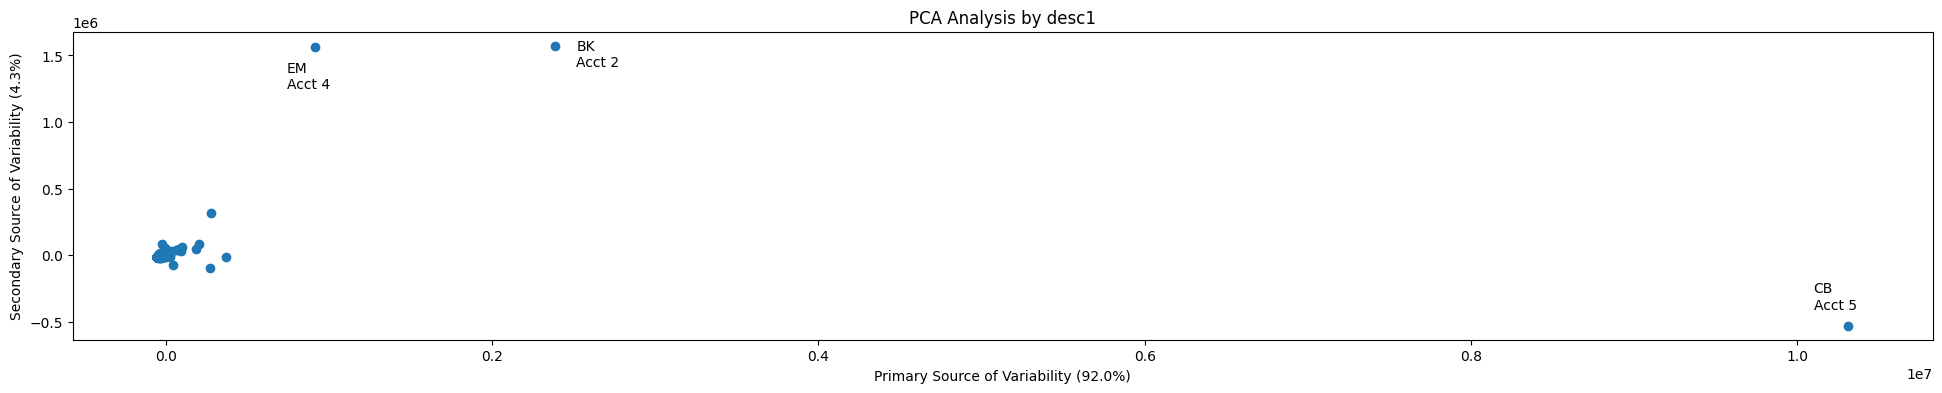

In [173]:
# np.argmax(pca.components_[0])
# X_pca
pca = PCA(n_components=2, random_state=0)
X_trends = df_trends.drop("trends", axis = 1).sum(axis = 1).unstack("desc1").reset_index().drop(["fyear", "Period"], axis = 1).T.fillna(0)
X_pca = pca.fit_transform(X_trends)
X_trends["pca1"], X_trends["pca2"] = X_pca[:,0], X_pca[:,1]
X_trends["pca_tuple"] = X_trends.apply(lambda x: (x.pca1, x.pca2), axis = 1)
plt.figure(figsize = (24,4))
plt.scatter(x = X_trends.pca1, y = X_trends.pca2)
plt.title("PCA Analysis by desc1")
plt.xlabel(f"Primary Source of Variability ({round(pca.explained_variance_ratio_[0]*100, 1)}%)")
plt.ylabel(f"Secondary Source of Variability ({round(pca.explained_variance_ratio_[1]*100, 1)}%)")

for desc1, acct, offset in zip(["CB", "EM", "BK"], ["Acct 5", "Acct 4", "Acct 2"], [(-25, 12), (-20, -30), (15, -15)]):
    plt.annotate(f"{desc1}\n{acct}", xy = X_trends.pca_tuple[desc1], xytext = offset, textcoords = "offset points") #TODO: Adjust annotation for aesthics

In [174]:
pd.options.display.float_format = '{:,.0f}%'.format
print_str = "Top 3 desc1s constituent accounts"
print(print_str)
print("-"*len(print_str))
display(pd.concat([
            (dh.df.query("desc1 == 'CB'").groupby("Account").txn_amt.sum()/dh.df.query("desc1 == 'CB'").txn_amt.sum()).sort_values(ascending = False).rename("CB").head(2),
            (dh.df.query("desc1 == 'EM'").groupby("Account").txn_amt.sum()/dh.df.query("desc1 == 'EM'").txn_amt.sum()).sort_values().rename("EM").tail(1),
            (dh.df.query("desc1 == 'BK'").groupby("Account").txn_amt.sum()/dh.df.query("desc1 == 'BK'").txn_amt.sum()).sort_values().rename("BK").tail(1)
        ], axis = 1).fillna(0)*100
)
pd.options.display.float_format = '{:,.2f}'.format

Top 3 desc1s constituent accounts
---------------------------------


,CB,EM,BK
Account,,,
Acct 5,59%,0%,0%
Acct 4,42%,102%,0%
Acct 2,0%,0%,95%


['Acct 5', 'Acct 4', 'Acct 2']

In [106]:
TOP3_DESC1_LIST = ["CB", "EM", "BK"]

In [209]:
dh.df.groupby(["period_fyear", "desc1"]).txn_amt.sum().reset_index().groupby("desc1").txn_amt.agg(["sum", "std"]).sort_values("sum", ascending = False).head(10)

,sum,std
desc1,,
CB,"56,456,893.72","916,072.58"
BK,"19,422,808.07","165,409.95"
EM,"7,735,422.08","297,294.39"
AD,"4,293,716.14","81,708.43"
CI,"2,848,992.38","203,967.17"
DM,"1,709,711.51","78,819.04"
GY,"1,702,654.34","132,016.93"
CG,"1,584,250.33","22,481.01"
AJ,"1,289,080.22","10,934.96"


# Large Repeating Transactions Section

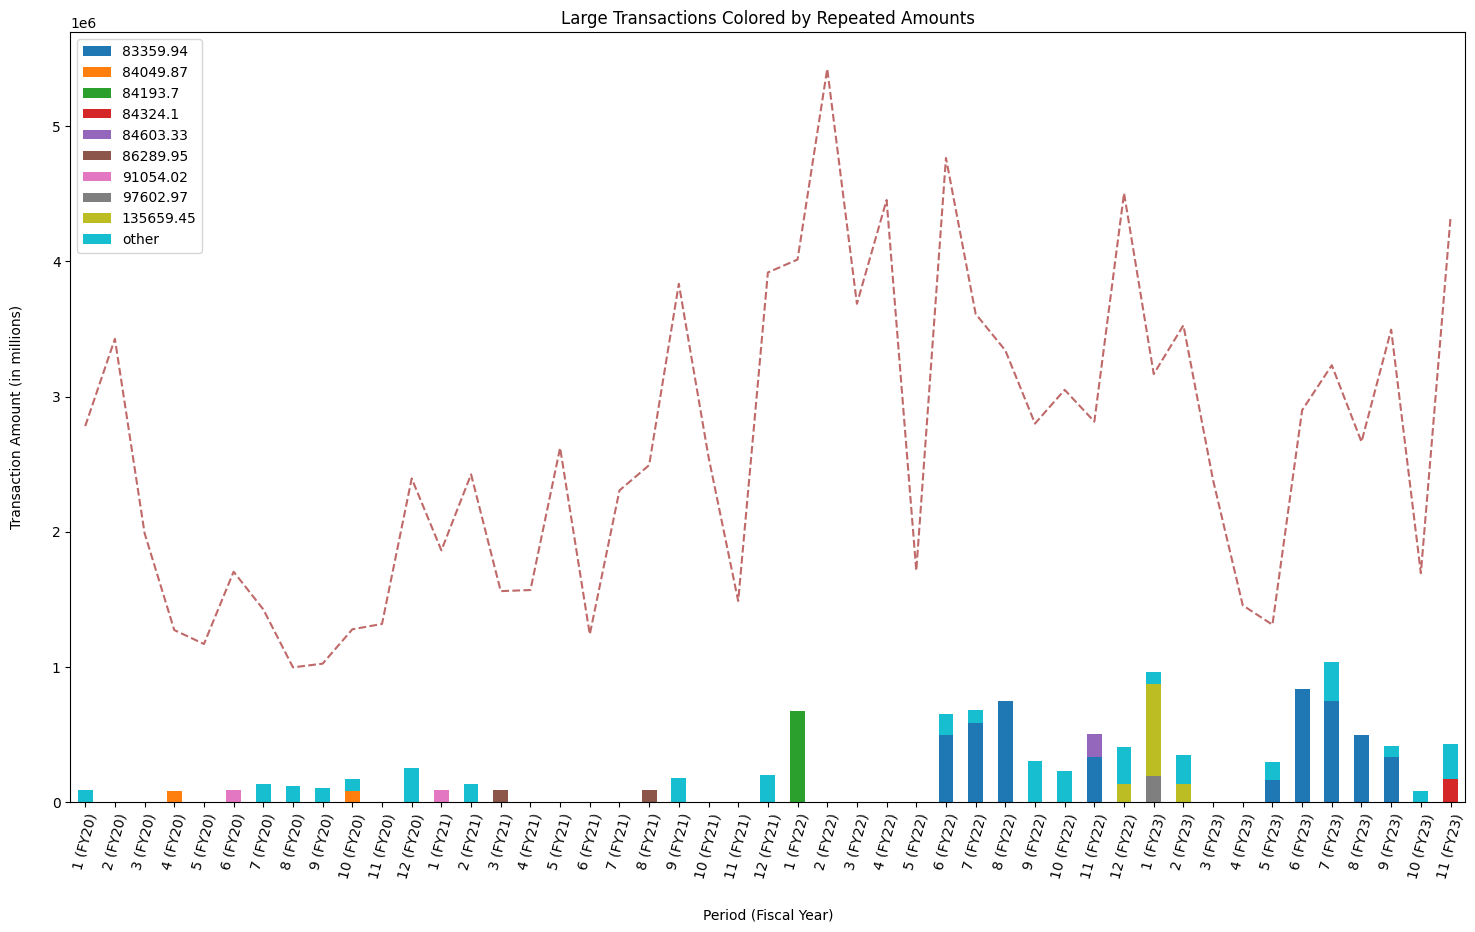

In [128]:
large_txns = dh.df.query("Debit <= Debit.quantile(0.001)")[["period_fyear", "Debit"]].Debit.value_counts().where(lambda x: x >= 2).dropna().index
large_txn_labels = dh.df.query("Debit <= Debit.quantile(0.001)")[["period_fyear", "Debit"]].Debit.apply(lambda x: -1*x if x in large_txns else np.inf).replace(np.inf, "other")

df_large_txns_crosstab = (dh.df
    .groupby("period_fyear")[["txn_amt"]]
    .sum()
    .join(pd.pivot_table(
                            data = dh.df.query("Debit <= Debit.quantile(0.001)")[["period_fyear", "Debit"]].eval("Debit = -1*Debit"), 
                            index = "period_fyear", 
                            columns = large_txn_labels, 
                            values = "Debit", 
                            aggfunc = "sum"
                        )
        )
                            .fillna(0)                  
)

(df_large_txns_crosstab
    .drop("txn_amt", axis = 1)
    .set_index(
                dh.df[["Period", "fyear", "period_fyear"]]
                    .drop_duplicates()
                    .apply(lambda x: str(x.Period) + " (FY" + str(x.fyear)[-2:]+")", axis = 1)
            )
    .shift(0)
    .plot(
            kind = "bar", 
            stacked = True, 
            figsize = (18,10), 
            zorder = 2
        )
)
plt.plot(dh.df.groupby("period_fyear").txn_amt.sum(), color = "brown", linestyle = "dashed", alpha = 0.7, zorder = 1)
plt.title("Large Transactions Colored by Repeated Amounts")
plt.ylabel("Transaction Amount (in millions)", labelpad=20)
plt.xlabel("Period (Fiscal Year)", labelpad=20)
plt.xticks(rotation = 75);

In [129]:
#*
print_str = "Top 3 desc1s large repeating transaction amounts"
print(print_str)
print("-"*len(print_str))
(dh.df
    .query("Debit in @large_txns and desc1 in @TOP3_DESC1_LIST")[["desc1", "Debit"]]
    .set_index("desc1")
    .squeeze()
    .apply(np.abs)
    .reset_index()
    .value_counts()
    .sort_index()
    .to_frame()
)

Top 3 desc1s large repeating transaction amounts
------------------------------------------------


count
desc1 Debit            
BK    84,049.87       2
      91,054.02       2
CB    84,193.70       8
EM    83,359.94      57
      97,602.97       2
      135,659.45      7

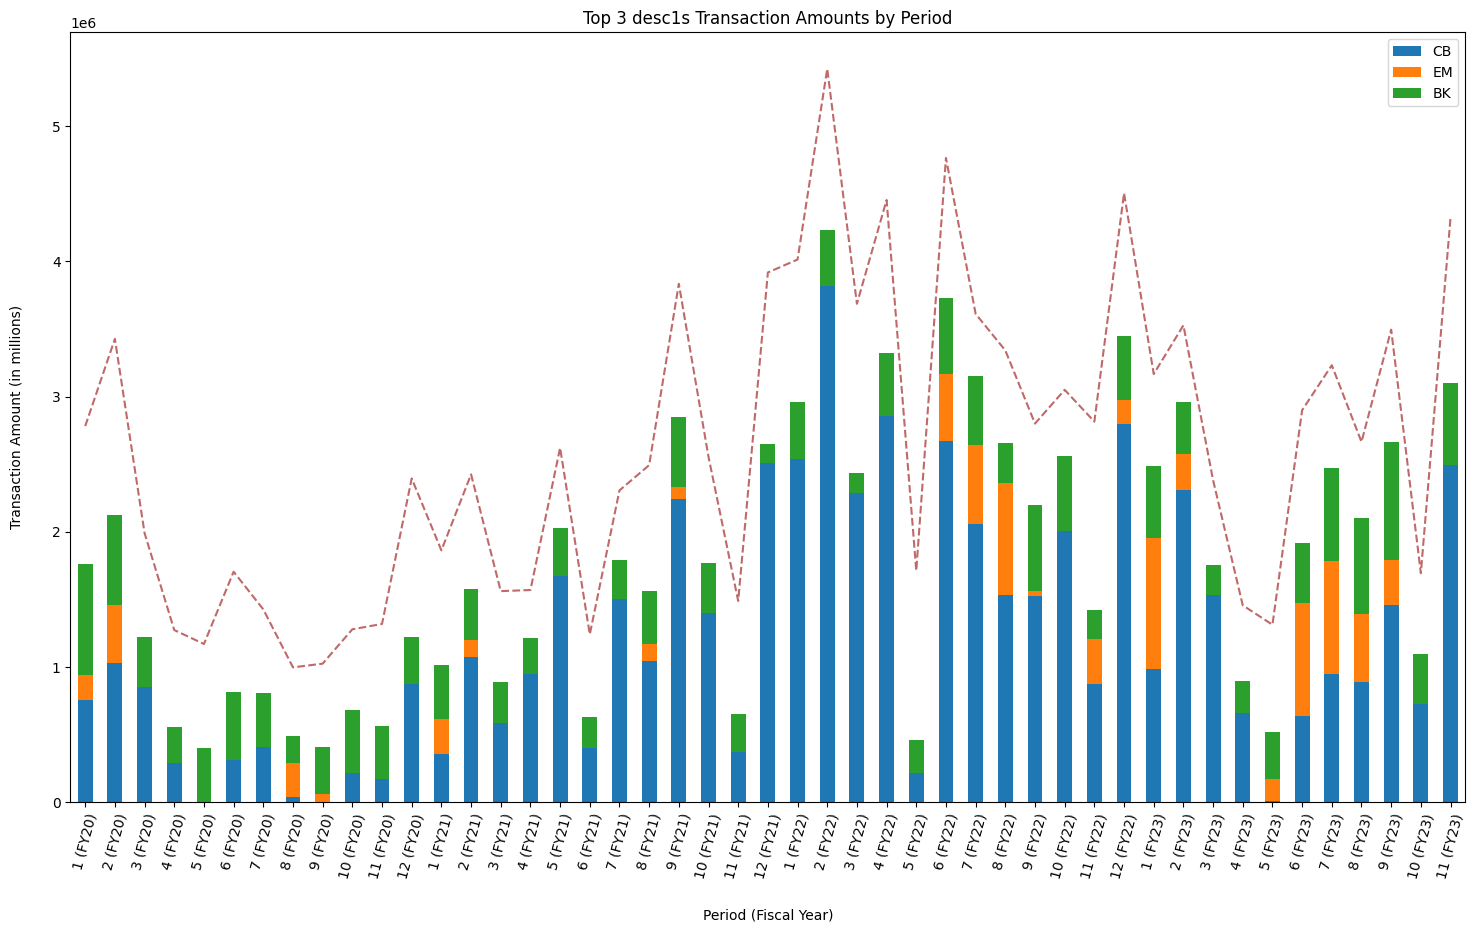

In [133]:
df_top3_desc1_crosstab = (dh.df
    .groupby("period_fyear")[["txn_amt"]]
    .sum()
    .join(dh.df.query("desc1 in @TOP3_DESC1_LIST")[["desc1", "period_fyear", "Debit"]].eval("Debit = -1*Debit").pivot_table(index = "period_fyear", columns = "desc1", values = "Debit", aggfunc = "sum")
        )
    .fillna(0)                  
)

(df_top3_desc1_crosstab
    .drop("txn_amt", axis = 1)
    .set_index(
                dh.df[["Period", "fyear", "period_fyear"]]
                    .drop_duplicates()
                    .apply(lambda x: str(x.Period) + " (FY" + str(x.fyear)[-2:]+")", axis = 1)
            )
    .shift(0)
    [["CB", "EM", "BK"]]
    .plot(
            kind = "bar", 
            stacked = True, 
            figsize = (18,10), 
            zorder = 2
        )
)
plt.plot(dh.df.groupby("period_fyear").txn_amt.sum(), color = "brown", linestyle = "dashed", alpha = 0.7, zorder = 1)
plt.title("Top 3 desc1s Transaction Amounts by Period")
plt.ylabel("Transaction Amount (in millions)", labelpad=20)
plt.xlabel("Period (Fiscal Year)", labelpad=20)
plt.xticks(rotation = 75);

# Seasonal Decomposition EDA

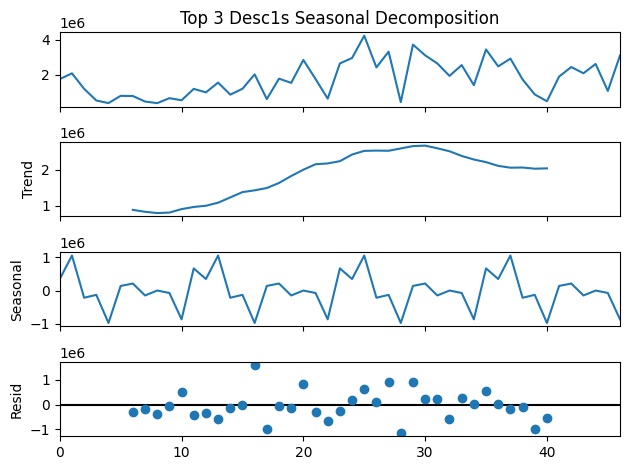

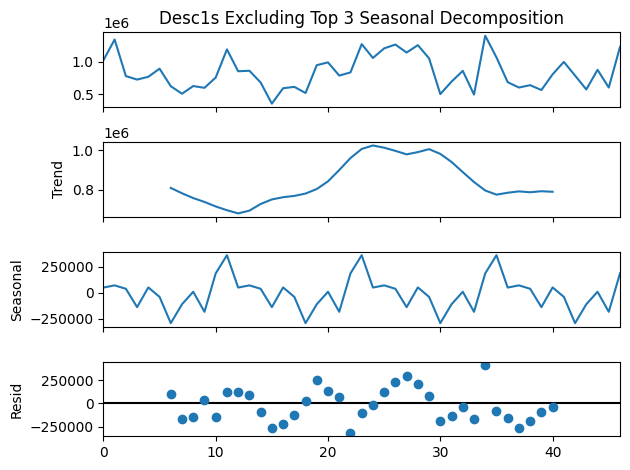

In [147]:
seasonal_decompose(dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Top 3 Desc1s Seasonal Decomposition"), period = 12).plot()
plt.show()
seasonal_decompose(dh.df.query("desc1 not in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Desc1s Excluding Top 3 Seasonal Decomposition"), period = 12).plot();

In [151]:
dh.df.describe(include = "all")

,desc1,desc2,Description,Period,Date,Organization,Account,Debit,Credit,Balance,fyear,txn_type,txn_amt,month,day_of_week,week,week_fyear,month_fyear,period_fyear
count,76722,"76,724.00",76724,"76,724.00",76724,76724,76724,"73,564.00","3,160.00","76,724.00","76,724.00",76724,"76,724.00","76,724.00","76,724.00","76,724.00","76,724.00","76,724.00","76,724.00"
unique,354,NaN,13947,NaN,NaN,4,20,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,AU,NaN,KL 05827,NaN,NaN,Dept C,Acct 4,NaN,NaN,NaN,NaN,Debit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6640,NaN,100,NaN,NaN,50383,49691,NaN,NaN,NaN,NaN,73564,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,"6,986.23",NaN,6.38,2021-09-27 00:36:11.148532224,NaN,NaN,"-1,688.16",380.99,"-3,329,835.06","2,021.51",NaN,"1,602.94",6.83,2.14,27.89,104.70,24.39,23.48
min,NaN,0.00,NaN,1.00,2019-09-28 00:00:00,NaN,NaN,"-193,001.03",0.02,"-12,005,610.65","2,020.00",NaN,"-142,779.98",1.00,0.00,1.00,0.00,0.00,0.00
25%,NaN,"3,450.00",NaN,3.00,2020-10-29 00:00:00,NaN,NaN,-534.28,31.99,"-4,982,927.33","2,021.00",NaN,50.18,4.00,1.00,15.00,57.00,13.00,13.00
50%,NaN,"6,782.00",NaN,6.00,2021-10-14 00:00:00,NaN,NaN,-127.43,67.45,"-2,805,944.97","2,022.00",NaN,116.57,7.00,2.00,29.00,107.00,25.00,24.00
75%,NaN,"10,677.00",NaN,9.00,2022-09-08 00:00:00,NaN,NaN,-56.64,181.77,"-911,614.10","2,022.00",NaN,488.19,10.00,3.00,42.00,154.00,36.00,35.00
max,NaN,"13,946.00",NaN,12.00,2023-08-25 00:00:00,NaN,NaN,-0.05,"142,779.98","155,645.47","2,023.00",NaN,"193,001.03",12.00,5.00,53.00,204.00,47.00,46.00


# Feature Summary

In [192]:
display(dh.df[["desc1", "Description", "Organization", "Account"]].apply(lambda x: x.nunique()),
        pd.to_datetime(dh.df.Date.describe()[["min", "max"]]).dt.strftime("%m/%d/%Y")
)

desc1             355
Description     13947
Organization        4
Account            20
dtype: int64

min    09/28/2019
max    08/25/2023
Name: Date, dtype: object

In [204]:
dh.df.drop(["Organization", "Balance", "day_of_week", "month_fyear"], axis = 1)[['desc1', 'desc2', 'Description', 'Account', 'Debit',
       'Credit', 'txn_type', 'txn_amt', 'Date', 'fyear', 'month', 'Period',
       'period_fyear', 'week', 'week_fyear']]

,desc1,desc2,Description,Account,Debit,Credit,txn_type,txn_amt,Date,fyear,month,Period,period_fyear,week,week_fyear
0,AA,0,AA 00000,Acct 1,NaN,32.93,Credit,-32.93,2019-09-28,2020,9,1,0,39,0
1,AB,1,AB 00001,Acct 1,NaN,16.45,Credit,-16.45,2019-09-30,2020,9,1,0,40,1
2,AC,2,AC 00002,Acct 1,NaN,56.08,Credit,-56.08,2019-09-30,2020,9,1,0,40,1
3,AD,3,AD 00003,Acct 2,"-13,213.51",NaN,Debit,"13,213.51",2019-09-30,2020,9,1,0,40,1
4,AD,4,AD 00004,Acct 2,"-5,096.64",NaN,Debit,"5,096.64",2019-09-30,2020,9,1,0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76719,AU,13940,AU 13940,Acct 5,-104.22,NaN,Debit,104.22,2023-08-25,2023,8,11,46,34,204
76720,KN,13934,KN 13934,Acct 5,-35.28,NaN,Debit,35.28,2023-08-25,2023,8,11,46,34,204
76721,KN,13934,KN 13934,Acct 5,-29.31,NaN,Debit,29.31,2023-08-25,2023,8,11,46,34,204
76722,KN,13934,KN 13934,Acct 5,-17.65,NaN,Debit,17.65,2023-08-25,2023,8,11,46,34,204
